In [ ]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

<h1> Artist network basics</h1>

In [16]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
data_prefix = 'data/' # ../

from powerlaw import Fit, plot_ccdf

In [6]:
import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

In [3]:
### create channel_id_embed_dict 
dict_path = os.path.join(data_prefix, "channel_id_embed_dict.pkl")
if not os.path.exists(dict_path):
    cid_list = []
    with open(os.path.join(data_prefix, "artist_details.json"), 'r') as fin:
        for line in fin:
                artist_json = json.loads(line.rstrip())
                cid = artist_json['channel_id']
                cid_list.append(cid)
    cid_list = sorted(cid_list)
    cid_embed_dict = {cid : embed for embed, cid in enumerate(cid_list)}

    with open(dict_path, 'wb') as fout:
        pickle.dump(cid_embed_dict, fout)
    
else:
#     print("Dict exist.")
    with open(dict_path, 'rb') as fin:
        cid_embed_dict = pickle.load(fin)
        
num_artists = len(cid_embed_dict.keys())
print("num_artists: ", num_artists)


num_artists:  4435


In [2]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
embed_cid_dict = data_loader.embed_cid_dict
num_videos = data_loader.num_videos

In [3]:
### artist network from relevant network at cutoff 15
NUM_REL = 15
T = 63
edges = []
embed_indegree_dict = {embed: [set() for _ in range(T)] for embed in np.arange(num_artists)}  # daily indegree for each embed
embed_outdegree_dict = {embed: [set() for _ in range(T)] for embed in np.arange(num_artists)}  # bounded, non-Vevo removed?
# daily_indegree_list = []
zero_indegree_list = []  # percentage of zero indegree for each day
num_edges_list = []  # number of total edges for each day
# num_nodes_list = []   # number of total nodes for each day -> always constant to be the 60470 XXX

for t in range(T):
    filename = 'network_{0}.p'.format((datetime(2018, 9, 1) + timedelta(days=t)).strftime('%Y-%m-%d'))
    indegree_list = []
    daily_edges = set()
    with open(os.path.join(data_prefix, 'network_pickle', filename), 'rb') as fin:
        network_dict = pickle.load(fin)   # embed_tar: [(embed_src, pos_src, view_src), ...]
#         num_nodes_list.append(len(network_dict.keys()))
        
        for tar_embed in range(num_videos):
            tar_cid = embed_cid_dict[tar_embed]
            tar_embedc = cid_embed_dict[tar_cid]
            for x in network_dict[tar_embed]:
                if x[1] < NUM_REL:
                    src_cid = embed_cid_dict[x[0]]
                    src_embedc = cid_embed_dict[src_cid]
                    daily_edges.add((src_embedc, tar_embedc))
                    embed_indegree_dict[tar_embedc][t].add(src_embedc)
                    embed_outdegree_dict[src_embedc][t].add(tar_embedc)
        
        zero_indegrees = 0
        for tar_embedc in range(num_artists):
            if  len(embed_indegree_dict[tar_embedc][t])==0:
                zero_indegrees += 1
            
    zero_indegree_list.append(zero_indegrees / num_artists)
    edges.append(daily_edges)
    num_edges_list.append(len(daily_edges))
#     print('>>> Finish loading day {0}...'.format(t + 1))

print('>>> Network structure has been loaded!')

In [6]:
daily_indegree_list = [[len(embed_indegree_dict[i][t]) for i in range(num_artists)] for t in range(T)]
daily_outdegree_list = [[len(embed_outdegree_dict[i][t]) for i in range(num_artists)] for t in range(T)]
max_outdegree = max([max(i) for i in daily_outdegree_list])
max_indegree = max([max(i) for i in daily_indegree_list])
print("max_outdegree: ", max_outdegree)
print("max_indegree: ", max_indegree)

max_outdegree:  168
max_indegree:  1054


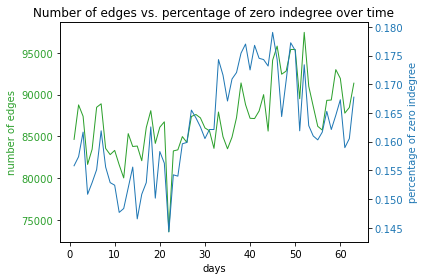

In [7]:
### Plot Number of edges vs. percentage of zero indegree over time 
fig, ax1 = plt.subplots()

ax1.set_title("Number of edges vs. percentage of zero indegree over time")

color = 'tab:green'
ax1.set_xlabel('days')
ax1.set_ylabel('number of edges', color=color)
ax1.plot([*range(1,64)], num_edges_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('percentage of zero indegree', color=color)  # we already handled the x-label with ax1
ax2.plot([*range(1,64)], zero_indegree_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Surperising. The percentage of zero indegree shares the same trend as number of edges.

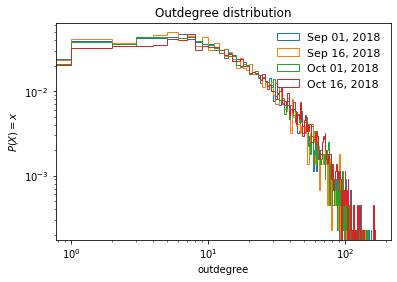

In [8]:
### Plot outdegree distribution
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(daily_outdegree_list[i], bins=[*range(0, max_outdegree, 1)], density=True, log=True, histtype="step", label=date_labels[int(i/15)])
plt.xscale('log')
plt.title("Outdegree distribution")
plt.xlabel("outdegree")
plt.ylabel('$P(X) = x$')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

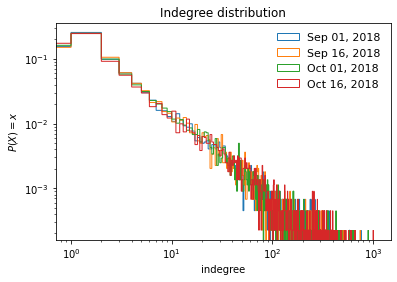

In [9]:
### Plot indegree distribution
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(daily_indegree_list[i], bins=[*range(0, max_indegree, 1)], density=True, log=True, histtype="step", label=date_labels[int(i/15)])
plt.xscale('log')
plt.title("Indegree distribution")
plt.xlabel("indegree")
plt.ylabel('$P(X) = x$')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

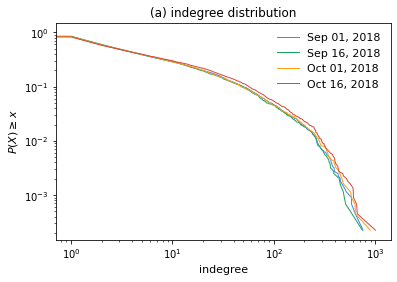

In [32]:
### powerlaw ccdf

fig, ax1 = plt.subplots()
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plot_ccdf(daily_indegree_list[i], ax=ax1, color=ColorPalette.CC4[int(i/15)], label=date_labels[int(i/15)])
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('indegree', fontsize=11)
ax1.set_ylabel('$P(X) \geq x$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Indegree distribution', fontsize=12)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

plt.show()

In [7]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "artist_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "artist_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "artist_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [11]:
### creat list of length of largest strongly/weakly connected components of each day (percentage)
lscc_list = [len(max(nx.strongly_connected_components(G), key=len))/num_artists for G in graph_lst]
lwcc_list = [len(max(nx.weakly_connected_components(G), key=len))/num_artists for G in graph_lst]

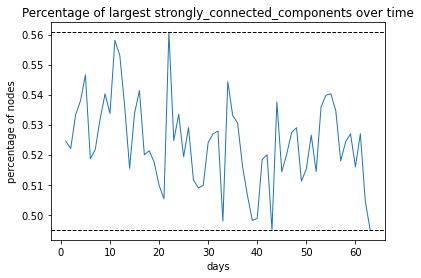

In [37]:
### Plot percentage of largest strongly_connected_components over time
plt.plot([*range(1,64)], lscc_list)
plt.axhline(y=max(lscc_list), color='k', linestyle='--', zorder=30)
plt.axhline(y=min(lscc_list), color='k', linestyle='--', zorder=30)
plt.title("Percentage of largest strongly_connected_components over time")
plt.xlabel("days")
plt.ylabel("percentage of nodes")
plt.show();

The proportion of LSCC fluctuates quite frequently and there are cliffs like on day 22.

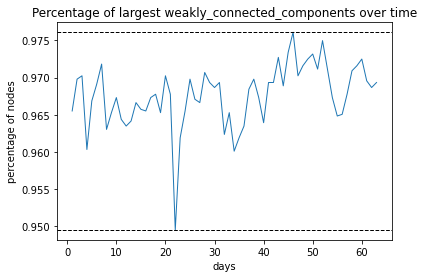

In [38]:
### Plot percentage of largest weakly_connected_components over time
plt.plot([*range(1,64)], lwcc_list)
plt.axhline(y=max(lwcc_list), color='k', linestyle='--', zorder=30)
plt.axhline(y=min(lwcc_list), color='k', linestyle='--', zorder=30)
plt.title("Percentage of largest weakly_connected_components over time")
plt.xlabel("days")
plt.ylabel("percentage of nodes")
plt.show();

Not supurising, since nearly all videos are weakly connected.

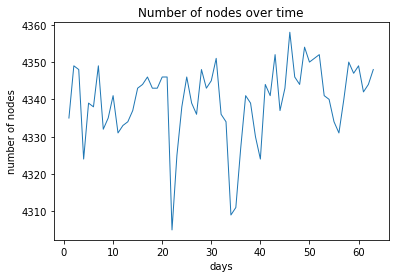

In [39]:
### Plot number of nodes actually in the network graph over time
num_nodes_list = [nx.number_of_nodes(G) for G in graph_lst]
plt.plot([*range(1,64)], num_nodes_list)
plt.title("Number of nodes over time")
plt.xlabel("days")
plt.ylabel("number of nodes")
plt.show();

The change of number of nodes may relevant to the percentage of LSCC. 

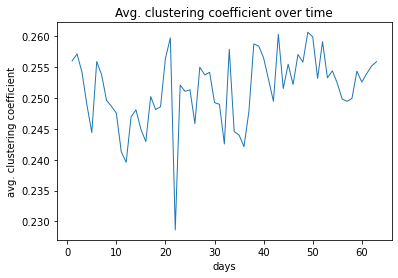

In [9]:
### Plot Avg. clustering coefficient over tim ~ 5 MIN
def avg_over_iterator(iterator):
    s = 0
    c = 0
    for j in iterator.values():
        s += j
        c += 1
    return s/c

cluster_list = [nx.clustering(G) for G in graph_lst]
avg_cluster_coef_list = [avg_over_iterator(i) for i in cluster_list]
plt.plot([*range(1,64)], avg_cluster_coef_list)
plt.title("Avg. clustering coefficient over time")
plt.xlabel("days")
plt.ylabel("avg. clustering coefficient")
plt.show();

Cluster coefficient doesn't change much. Day 21 is interesting.

In [8]:
### Caculate pagerank and eigenvector centrality 
if not os.path.exists(os.path.join(data_prefix, "artist_env_list_15.pkl")):
    env_list = [nx.eigenvector_centrality_numpy(G) for G in graph_lst]
    with open(os.path.join(data_prefix, "artist_env_list_15.pkl"), 'wb') as fout:
            pickle.dump(env_list, fout)
else:
    with open(os.path.join(data_prefix, "artist_env_list_15.pkl"), 'rb') as fin:
        env_list = pickle.load(fin)

if not os.path.exists(os.path.join(data_prefix, "artist_pr_list_15.pkl")):
    pr_list = [nx.pagerank_scipy(G) for G in graph_lst]
    with open(os.path.join(data_prefix, "artist_pr_list_15.pkl"), 'wb') as fout:
            pickle.dump(pr_list, fout)
else:
    with open(os.path.join(data_prefix, "artist_pr_list_15.pkl"), 'rb') as fin:
        pr_list = pickle.load(fin)

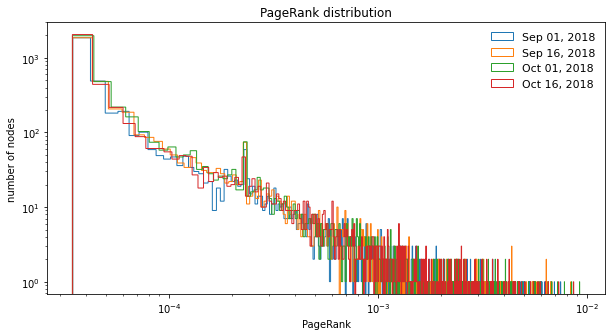

In [22]:
### take 4 days as an example
plt.figure(figsize=(10,5))
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(list(pr_list[i].values()),bins=1000, log=True, histtype="step", label=date_labels[int(i/15)]) # density=True,  
plt.title("PageRank distribution")
plt.xlabel("PageRank")
plt.ylabel("number of nodes")
plt.xscale('log')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

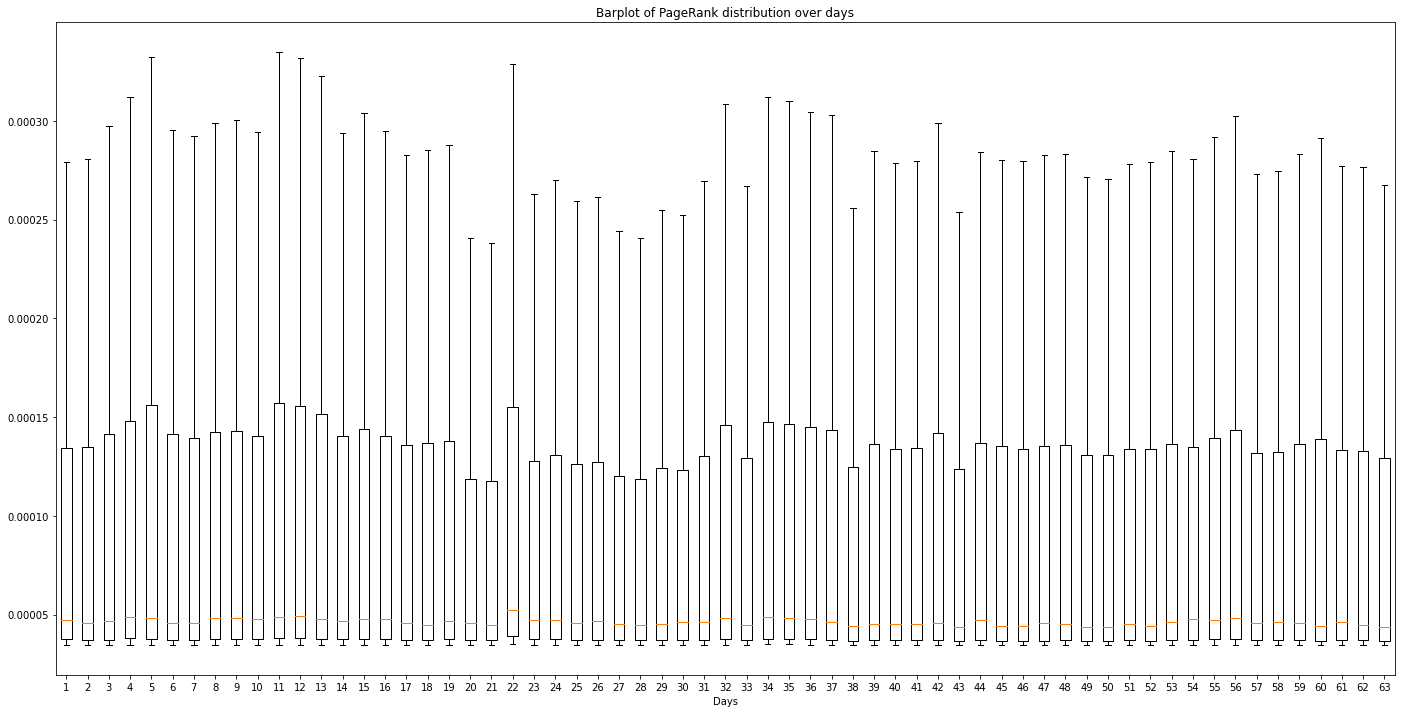

In [24]:
### pagerank analysis
### Plot boxplot
plt.figure(figsize=(24,12))
plt.boxplot([list(i.values()) for i in pr_list], labels=[*range(1,64)], showfliers=False)
## there exists many large outliers being hidden, which may actually be the hot spots we interested in
plt.title("Barplot of PageRank distribution over days")
plt.xlabel("Days")
plt.show();

There exists many large outliers being hidden, which may actually be the hot spots we interested in.

It's actually hard for me to tell something from graphs of KL-Divergence and histigram intersection. 
Again, eigenvector centrality might not be right.

In [15]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

def get_hi_kl_list(lst):
    maximum = max([max(i.values()) for i in lst])
    minimum = min([min(i.values()) for i in lst])
    bins = np.linspace(minimum, maximum, 1000)
    pre, bins, _ = plt.hist(list(lst[0].values()),bins=bins, log=True, density=True);
    hi_list = []
    kl_list = []
    for i in range(1, len(lst)):
        h2, _, _ = plt.hist(list(lst[i].values()),bins=bins, log=True, density=True);
        hi_list.append(histogram_intersection(pre, h2, bins))

        pre_np = np.array(pre)+1
        h2_np = np.array(h2)+1
        kl_list.append(sp.stats.entropy(h2_np, pre_np))
        
        pre = h2
        
    return hi_list, kl_list

pr_hi_list, pr_kl_list= get_hi_kl_list(pr_list);
env_hi_list, env_kl_list= get_hi_kl_list(env_list);

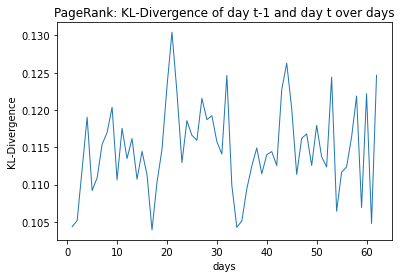

In [11]:
### PageRank: KL-Divergence
plt.plot([*range(1, 63)], pr_kl_list)
plt.title("PageRank: KL-Divergence of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("KL-Divergence")
plt.show()

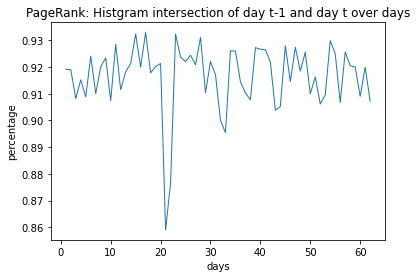

In [12]:
### PageRank: Histgram intersection
plt.plot([*range(1, 63)], pr_hi_list)
plt.title("PageRank: Histgram intersection of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("percentage")
plt.show()

Day 21.

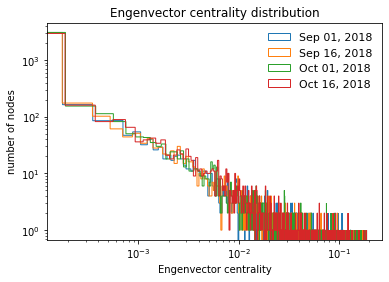

In [61]:
### Engenvector centrality distibution: take 4 days as an example
# plt.figure(figsize=(10,5))
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15, 30, 45]:
    plt.hist(list(env_list[i].values()),bins=1000, log=True, histtype="step", label=date_labels[int(i/15)]) # density=True,  
plt.title("Engenvector centrality distribution")
plt.xlabel("Engenvector centrality")
plt.ylabel("number of nodes")
plt.xscale('log')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();
## Extremely distributed if not logarized

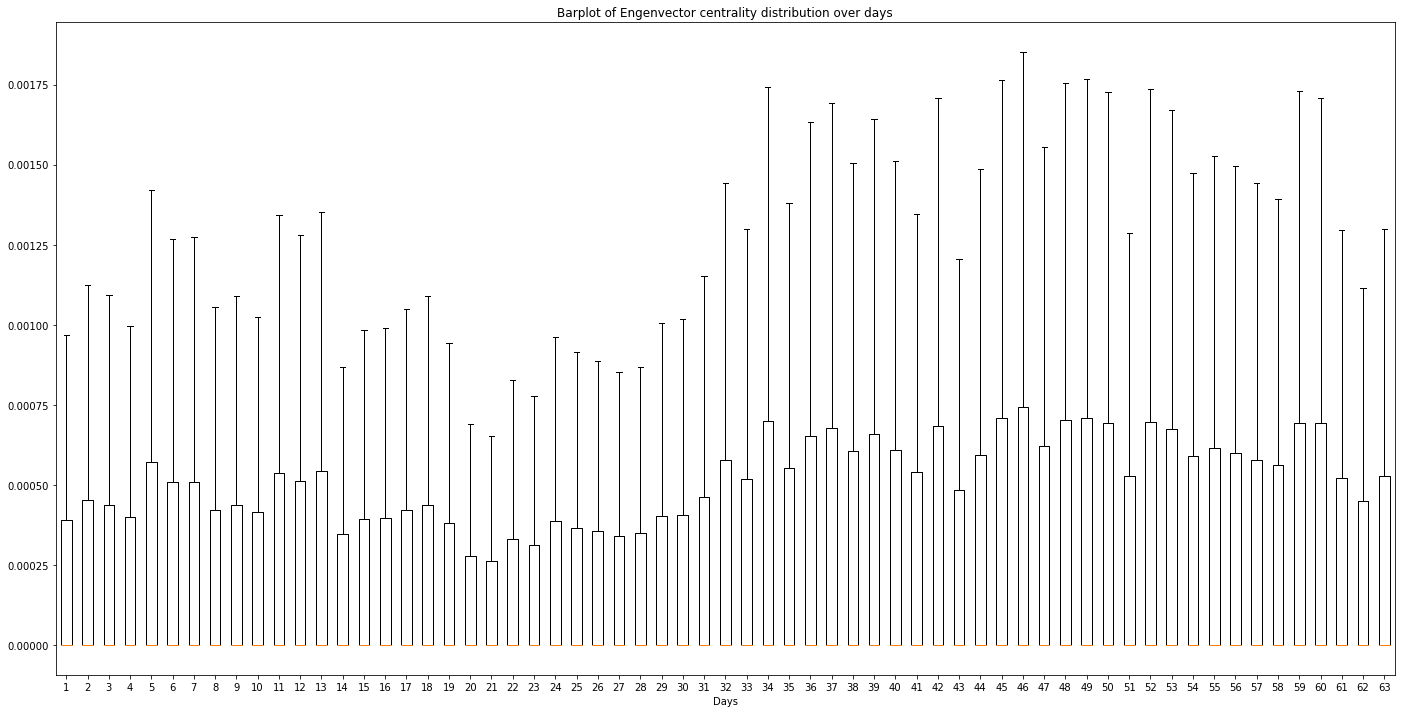

In [63]:
### Engenvector centrality boxplot
plt.figure(figsize=(24,12))
plt.boxplot([list(i.values()) for i in env_list], labels=[*range(1,64)], showfliers=False)
## there exists many large outliers being hidden, which may actually be the hot spots we interested in
plt.title("Barplot of Engenvector centrality distribution over days")
plt.xlabel("Days")
plt.show();

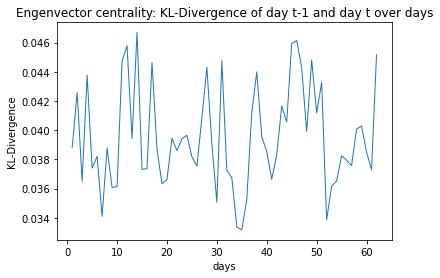

In [13]:
### Engenvector centrality KL-Divergence
plt.plot([*range(1, 63)], env_kl_list)
plt.title("Engenvector centrality: KL-Divergence of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("KL-Divergence")
plt.show()

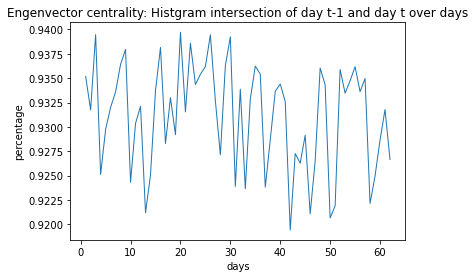

In [14]:
### Engenvector centrality Histgram intersection
plt.plot([*range(1, 63)], env_hi_list)
plt.title("Engenvector centrality: Histgram intersection of day t-1 and day t over days")
plt.xlabel("days")
plt.ylabel("percentage")
plt.show()